## Dissertation Project - News Summary Dissertation [100 marks]

### Motivation 

> 1. Provide tools for anyone needing to speed up their research process
> 2. Providing ways for user to quickly determine whether a piece of research is beneficial for their specific search terms




### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image
import string
import random
from operator import xor

import numpy as np 
import pandas as pd

import json

DATASET = "./Dataset/"

Detect which device (CPU/GPU) to use.

In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) 
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Overview

Summarisation model
> 1. Dataset preprocessing
> 2. Dataloader
> 3. RNN model definition
> 4. Model training
> 5. Model prediction evaluation
> 6. Dataset Exploration
> 7. Dataset modification/Data Augmentation
> 8. Model improvement
> 9. Model finalisation and evaluation

Paper querying
> 1. Attention on query (Return usefulness percentage
> 2. Evaluate performance


# Data preprocessing

In [3]:
# Comment this block if dataset is reorganised
# DATA_DIR = "SSN/papers.SSN.jsonl"
# dataset_path = DATASET+DATA_DIR
# with open(dataset_path) as f:
#     lines = f.read().splitlines()
# df_inter = pd.DataFrame(lines)
# df_inter.columns = ['json_element']
# df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))
# df_final.to_json("./Dataset/SSN/SSN_Dataset.json")
# df_final

,paper_id,title,abstract,section_names,domain,text
0,4650265,XGBoost: A Scalable Tree Boosting System,[tree boosting is a highly effective and widel...,"[introduction, tree boosting in a nutshell, re...",[],[[machine learning and data - driven approache...
1,9195903,Robust Face Alignment Using a Mixture of Invar...,"[face alignment , which is the task of finding...","[introduction, previous work, our approach, su...",[Computer science],[[face alignment refers to finding the pixel l...
2,119332442,Modulation instability associated nonlinear dy...,[we study pattern - forming nonlinear dynamics...,"[introduction, modulation instability of becs ...",[Physics],[[modulation instability ( mi ) is one of the ...
3,13494452,Free evolution on algebras with two states,[the key result in the paper concerns two tran...,"[introduction, preliminaries, polynomials and ...",[Mathematics],[[in a series of papers belinschi and nica int...
4,119269876,Light Dilaton at Fixed Points and Ultra Light ...,[we investigate the infrared dynamics of a non...,"[introduction, a comment on the large nn and n...",[Physics],[[understanding strong dynamics constitutes a ...
...,...,...,...,...,...,...
140794,12157610,Minimal and Maximal Operator Spaces and Operat...,[we examine k - minimal and k - maximal operat...,"[introduction, quantum information theory prel...",[Mathematics],[[a primary goal of this paper is to formally ...
140795,14690185,AN OBSTRUCTION TO ASYMPTOTIC SEMISTABILITY AND...,"[in this paper , we consider an obstruction to...","[introduction, statement of results, an obstru...",[Mathematics],[[for a polarized algebraic manifold inlinefor...
140796,15296646,Direct Detection of Neutralino Dark Matter and...,[we compare predictions for the spin - indepen...,"[introduction, msugra, more general models, co...",[Physics],[[the minimal supersymmetric standard model ( ...
140797,119576690,PCA by Optimisation of Symmetric Functions has...,[principal component analysis ( pca ) finds th...,"[introduction, pca by determinant optimisation...",[Mathematics],"[[let inlineform0 be a data matrix , with rows..."


In [4]:
# for i,summary in df_final.iterrows():
#     temp = summary["abstract"]
#     print(type(summary["abstract"]))
#     break

<class 'list'>


In [3]:
# Comment this block if dataset is shortened
# DATA_DIR = "SSN/SSN_Dataset.json"
# dataset_path = DATASET+DATA_DIR
# df = pd.read_json(dataset_path)
# df

,paper_id,title,abstract,section_names,domain,text
0,4650265,XGBoost: A Scalable Tree Boosting System,[tree boosting is a highly effective and widel...,"[introduction, tree boosting in a nutshell, re...",[],[[machine learning and data - driven approache...
1,9195903,Robust Face Alignment Using a Mixture of Invar...,"[face alignment , which is the task of finding...","[introduction, previous work, our approach, su...",[Computer science],[[face alignment refers to finding the pixel l...
2,119332442,Modulation instability associated nonlinear dy...,[we study pattern - forming nonlinear dynamics...,"[introduction, modulation instability of becs ...",[Physics],[[modulation instability ( mi ) is one of the ...
3,13494452,Free evolution on algebras with two states,[the key result in the paper concerns two tran...,"[introduction, preliminaries, polynomials and ...",[Mathematics],[[in a series of papers belinschi and nica int...
4,119269876,Light Dilaton at Fixed Points and Ultra Light ...,[we investigate the infrared dynamics of a non...,"[introduction, a comment on the large nn and n...",[Physics],[[understanding strong dynamics constitutes a ...
...,...,...,...,...,...,...
140794,12157610,Minimal and Maximal Operator Spaces and Operat...,[we examine k - minimal and k - maximal operat...,"[introduction, quantum information theory prel...",[Mathematics],[[a primary goal of this paper is to formally ...
140795,14690185,AN OBSTRUCTION TO ASYMPTOTIC SEMISTABILITY AND...,"[in this paper , we consider an obstruction to...","[introduction, statement of results, an obstru...",[Mathematics],[[for a polarized algebraic manifold inlinefor...
140796,15296646,Direct Detection of Neutralino Dark Matter and...,[we compare predictions for the spin - indepen...,"[introduction, msugra, more general models, co...",[Physics],[[the minimal supersymmetric standard model ( ...
140797,119576690,PCA by Optimisation of Symmetric Functions has...,[principal component analysis ( pca ) finds th...,"[introduction, pca by determinant optimisation...",[Mathematics],"[[let inlineform0 be a data matrix , with rows..."


Function to return index for conclusion section

In [30]:
# Comment this block if dataset is shortened
# Trim text after conclusion
indexes = []
for i,row in df.iterrows():
    section = row["section_names"]
    #print(section)
    index = [section.index(x) for x in section if x.startswith('conclusion') or x.startswith("summar")]
    #print(index)
    if not index:
        indexes.append(i)
# dropping rows in dataframe that can't easily filter out reference section
df.drop(indexes)
df.to_json("./Dataset/SSN/SSN_Dataset_Short.json")

KeyboardInterrupt: 

35% of paper will be removed from the dataset due to it not having conclusion(s) and summary(ies) in their section titles, making it difficult to filter out the reference and appendix text

In [ ]:
DATA_DIR = "SSN/SSN_Dataset_Short.json"
dataset_path = DATASET+DATA_DIR
df = pd.read_json(dataset_path)
df

In [ ]:
def trim_index(row):
    return [row.index(x) for x in row if x.startswith('conclusion') or x.startswith("summar")]

In [8]:
summary_df = df[["text", "abstract"]]
summary_df

,text,abstract
0,[[machine learning and data - driven approache...,[tree boosting is a highly effective and widel...
1,[[face alignment refers to finding the pixel l...,"[face alignment , which is the task of finding..."
2,[[modulation instability ( mi ) is one of the ...,[we study pattern - forming nonlinear dynamics...
3,[[in a series of papers belinschi and nica int...,[the key result in the paper concerns two tran...
4,[[understanding strong dynamics constitutes a ...,[we investigate the infrared dynamics of a non...
...,...,...
140794,[[a primary goal of this paper is to formally ...,[we examine k - minimal and k - maximal operat...
140795,[[for a polarized algebraic manifold inlinefor...,"[in this paper , we consider an obstruction to..."
140796,[[the minimal supersymmetric standard model ( ...,[we compare predictions for the spin - indepen...
140797,"[[let inlineform0 be a data matrix , with rows...",[principal component analysis ( pca ) finds th...


Check if any columns contain empty values

In [7]:
summary_df.isnull().any()

text        False
abstract    False
dtype: bool

\'hi\' \ is used for space <br>
random space, which is used for reference [15] quote box <br>
sec ref is hyperlink to a section <br>
fig ref is hyperlink to a figure <br>
inlineform <br>
displayform are both symbols, both contains numbers in string <br>
remove all forms and remove all symbols but keep numbers <br>

In [8]:
summary_df.iloc[0]["text"]

[['machine learning and data - driven approaches are becoming very important in many areas .',
  'smart spam classifiers protect our email by learning from massive amounts of spam data and user feedback ; advertising systems learn to match the right ads with the right context ; fraud detection systems protect banks from malicious attackers ; anomaly event detection systems help experimental physicists to find events that lead to new physics .',
  'there are two important factors that drive these successful applications : usage of effective ( statistical ) models that capture the complex data dependencies and scalable learning systems that learn the model of interest from large datasets .',
  'among the machine learning methods used in practice , gradient tree boosting   is one technique that shines in many applications .',
  'tree boosting has been shown to give state - of - the - art results on many standard classification benchmarks   .',
  'lambdamart   , a variant of tree boosting 

In [10]:
for i,summary in summary_df.iterrows():
    temp = summary["abstract"]
    print(type(summary["abstract"]))
    print(summary["abstract"])
    break


for i in temp:
    print(i)

<class 'list'>
['tree boosting is a highly effective and widely used machine learning method .', 'in this paper , we describe a scalable end - to - end tree boosting system called xgboost , which is used widely by data scientists to achieve state - of - the - art results on many machine learning challenges .', 'we propose a novel sparsity - aware algorithm for sparse data and weighted quantile sketch for approximate tree learning .', 'more importantly , we provide insights on cache access patterns , data compression and sharding to build a scalable tree boosting system .', 'by combining these insights , xgboost scales beyond billions of examples using far fewer resources than existing systems .']
tree boosting is a highly effective and widely used machine learning method .
in this paper , we describe a scalable end - to - end tree boosting system called xgboost , which is used widely by data scientists to achieve state - of - the - art results on many machine learning challenges .
we p

In [181]:
def contain_let(string):
    return any(char.isalpha() for char in string)

In [182]:
def contain_num(string):
    return any(char.isdigit() for char in string)

In [241]:
def cleanLine(line):
    form_list = ["figref", "secref", "displayform", "inlineform", "uid"]
    # clean line = clean line remove punctuation
    
    clean_line = line.lower()
    clean_line = clean_line.strip()
    # clean line = clean line remove forms
    words = clean_line.split()
#     for form in form_list:
        # l_in = [s for s in l if 'XXX' in s]
        # if letter in string and letter also in string then it's one of those special chars
        #https://note.nkmk.me/en/python-list-str-select-replace.
        # l_replace = [s.replace('XXX', 'ZZZ') for s in l]
        # words = [x for x in words if contain_let(x) and contain_num(x)]
        #if and then will only list forms
        #if all not then will list all punct
        
    #words = [x for x in words if xor(contain_let(x), contain_num(x))]
    #  [0 if x % 2 == 1 else x for x in a]
    words = [x.replace(x, "") if contain_let(x) and contain_num(x) else x for x in words]
        

    
    #remove punctuation
    '''
    # replace all non alphabet character with space
    difference = list(set(words).symmetric_difference(alphabet))

    for dif in difference:
        words = words.replace(dif, " ")
    '''
    
    clean_line = ' '.join(words)
        
    return clean_line

In [242]:
test1 = ["hi", "i","am" ,"you"]
test2 = ["i", "am"]
print(test2 in test1)
print(test2[0] in test1[0])
#any(item.startswith(fruit) for fruit in listB)]
#filtered_ages = filter(lambda a: a > 50, ages)
# compare 1 item with every other item
#[x for x in sents if not x.startswith('@$\t')
test = test1
for filt in test2:
    test = [x.replace(filt, "OOOOO") for x in test if not x.startswith(filt)]
print(test)

False
True
['hOOOOO', 'you']


In [243]:
def concatParagraph(paragraph):
    clean_paragraph = ""
    for line in paragraph:
        clean_paragraph += cleanLine(line)
        
    return(clean_paragraph)
concatParagraph(summary_df.iloc[0]["abstract"])

'tree boosting is a highly effective and widely used machine learning method .in this paper , we describe a scalable end - to - end tree boosting system called xgboost , which is used widely by data scientists to achieve state - of - the - art results on many machine learning challenges .we propose a novel sparsity - aware algorithm for sparse data and weighted quantile sketch for approximate tree learning .more importantly , we provide insights on cache access patterns , data compression and sharding to build a scalable tree boosting system .by combining these insights , xgboost scales beyond billions of examples using far fewer resources than existing systems .'

In [244]:
def concatPaper(paper):
    clean_paper = ""
    for paragraph in paper:
        clean_paper += concatParagraph(paragraph)
    return(clean_paper)
concatPaper(summary_df.iloc[0]["text"])

"machine learning and data - driven approaches are becoming very important in many areas .smart spam classifiers protect our email by learning from massive amounts of spam data and user feedback ; advertising systems learn to match the right ads with the right context ; fraud detection systems protect banks from malicious attackers ; anomaly event detection systems help experimental physicists to find events that lead to new physics .there are two important factors that drive these successful applications : usage of effective ( statistical ) models that capture the complex data dependencies and scalable learning systems that learn the model of interest from large datasets .among the machine learning methods used in practice , gradient tree boosting is one technique that shines in many applications .tree boosting has been shown to give state - of - the - art results on many standard classification benchmarks .lambdamart , a variant of tree boosting for ranking , achieves state - of - th

In [131]:
# Normalisation transform - need to change
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [8]:
# Define a class COCOImagesDataset(Dataset) function that takes the 
# image file names and reads the image and apply transform to it
# ---> your code here! we have provided you a sketch 

class SSNDataset(Dataset):
    def __init__(self, df, transform=None):
        # df = array of all the file names

        self.df = df
        self.transform = transform
        # --> your code here!


    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']
        image = Image.open(os.path.join(IMAGE_DIR, filename)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        

        # --> your code here!


        return image, filename

    def __len__(self):
        return len(self.df)
    

# Dataloader

# RNN Model definition

In [9]:
class RNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(RNN, self).__init__()
        # Your code here!
#         resnet = models.resnet50(pretrained=True)
#         self.resnet = nn.Sequential(*(list(resnet.children())[:-1]))
#         self.linear = nn.Linear(2048,256)
        #print(resnet)

        # TO COMPLETE
        # keep all layers of the pretrained net except the last layers of fully-connected ones (you are permitted to take other layers too but this can affect your accuracy!)

        
    def forward(self, images):
        """Extract feature vectors from input images."""

        # TO COMPLETE
        # remember no gradients are needed
#         with torch.no_grad():
#             features = self.resnet(images)
#             features = features.reshape(features.size(0), -1)
#             features = self.linear(features)
#         return features


# Model training

# Model Evaluation

# Dataset Exploration

In [16]:
df

,paper_id,title,abstract,section_names,domain,text
0,4650265,XGBoost: A Scalable Tree Boosting System,['tree boosting is a highly effective and wide...,"['introduction', 'tree boosting in a nutshell'...",[''],[['machine learning and data - driven approach...
1,9195903,Robust Face Alignment Using a Mixture of Invar...,"['face alignment , which is the task of findin...","['introduction', 'previous work', 'our approac...",['Computer science'],[['face alignment refers to finding the pixel ...
2,119332442,Modulation instability associated nonlinear dy...,['we study pattern - forming nonlinear dynamic...,"['introduction', 'modulation instability of be...",['Physics'],[['modulation instability ( mi ) is one of the...
3,13494452,Free evolution on algebras with two states,['the key result in the paper concerns two tra...,"['introduction', 'preliminaries', 'polynomials...",['Mathematics'],[['in a series of papers belinschi and nica in...
4,119269876,Light Dilaton at Fixed Points and Ultra Light ...,['we investigate the infrared dynamics of a no...,"['introduction', 'a comment on the large nn an...",['Physics'],[['understanding strong dynamics constitutes a...
...,...,...,...,...,...,...
140794,12157610,Minimal and Maximal Operator Spaces and Operat...,['we examine k - minimal and k - maximal opera...,"['introduction', 'quantum information theory p...",['Mathematics'],[['a primary goal of this paper is to formally...
140795,14690185,AN OBSTRUCTION TO ASYMPTOTIC SEMISTABILITY AND...,"['in this paper , we consider an obstruction t...","['introduction', 'statement of results', 'an o...",['Mathematics'],[['for a polarized algebraic manifold inlinefo...
140796,15296646,Direct Detection of Neutralino Dark Matter and...,['we compare predictions for the spin - indepe...,"['introduction', 'msugra', 'more general model...",['Physics'],[['the minimal supersymmetric standard model (...
140797,119576690,PCA by Optimisation of Symmetric Functions has...,['principal component analysis ( pca ) finds t...,"['introduction', 'pca by determinant optimisat...",['Mathematics'],"[['let inlineform0 be a data matrix , with row..."


In [20]:
df.iloc[0]["text"]

'[[\'machine learning and data - driven approaches are becoming very important in many areas .\', \'smart spam classifiers protect our email by learning from massive amounts of spam data and user feedback ; advertising systems learn to match the right ads with the right context ; fraud detection systems protect banks from malicious attackers ; anomaly event detection systems help experimental physicists to find events that lead to new physics .\', \'there are two important factors that drive these successful applications : usage of effective ( statistical ) models that capture the complex data dependencies and scalable learning systems that learn the model of interest from large datasets .\', \'among the machine learning methods used in practice , gradient tree boosting   is one technique that shines in many applications .\', \'tree boosting has been shown to give state - of - the - art results on many standard classification benchmarks   .\', \'lambdamart   , a variant of tree boostin

In [58]:
def get_df_lengths(df):
    ratio = []
    for i,row in df.iterrows():
        article = len(row["article"].split())
        highlight = len(row["highlights"].split())
        if (i==137538):
            print(row["article"])
            print("---------------------")
            print(row["highlights"])
        ratio.append(highlight/article)
    return ratio

In [59]:
ratio = get_df_lengths(df)

Downton Abbey's famously grim butler, Mr Bates .
---------------------
And now for the good news . . . Following a particularly grim week, here’s a compendium of some of the world’s most comforting headlines: .
Supermodel Smiles On Catwalk .
Jack Russell Dog Welcomes Stranger .
Child At Funfair ‘Delighted’ By Goldfish .
Katie Price Breasts ‘Roughly Same Size As Last Week’ Say Experts .
Teenager Looks Up From Phone, Greets Parent .
Political Pundits Agree To Stop Discussing Hung Parliament For Next Three Months .
Diner Finishes His Curly Kale .
Pensioner Looks Great In Party Hat .
Celebrity Fails To Compare Life To Roller-coaster .
Pet Hamster Repays Child’s Affection .
‘Cheer Up, It May Never Happen’ — Downton’s Mr Bates Enjoys Belly-laugh .
Style Journalist Fails To Employ The Word ‘Iconic’
Sally Bercow Goes Out On Town, Retains Dignity .
Entire Windfarm Operates According To Plan .
Miley Cyrus Feels A Bit Chilly, Opts For Extra Layer .


In [47]:
ratio

[0.18686868686868688,
 0.09693877551020408,
 0.0853960396039604,
 0.09981167608286252,
 0.11551724137931034,
 0.12574850299401197,
 0.03099730458221024,
 0.08695652173913043,
 0.09688013136288999,
 0.06306306306306306,
 0.09338235294117647,
 0.09428129829984544,
 0.04805914972273567,
 0.14903846153846154,
 0.05941845764854614,
 0.12058212058212059,
 0.03619909502262444,
 0.05114029025570145,
 0.14392059553349876,
 0.09248554913294797,
 0.11290322580645161,
 0.06223175965665236,
 0.025252525252525252,
 0.0670807453416149,
 0.07357357357357357,
 0.059931506849315065,
 0.0497335701598579,
 0.04749512036434613,
 0.22916666666666666,
 0.12189616252821671,
 0.10119840213049268,
 0.04323094425483504,
 0.09049773755656108,
 0.022063208109719738,
 0.10561797752808989,
 0.16293929712460065,
 0.058163265306122446,
 0.11014492753623188,
 0.04020979020979021,
 0.13213213213213212,
 0.1079734219269103,
 0.05200945626477541,
 0.07241379310344828,
 0.07616707616707617,
 0.09510869565217392,
 0.1128472

In [50]:
max(ratio)

19.0

In [51]:
ratio.index(max(ratio))

137538

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


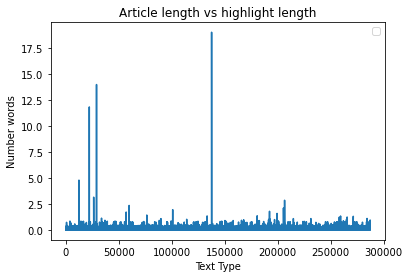

In [48]:
sep = np.arange(len(art_len))

plt.plot(ratio)

plt.xlabel("Text Type")
plt.ylabel("Number words")
plt.title("Article length vs highlight length")
plt.legend()
plt.show()

In [29]:
df.isnull().any()

id            False
article       False
highlights    False
dtype: bool

After exploring, all highlight:article ratio being more than 1.0 means the summary text is producing more text than the original text, this defeats the purpose of the model, therefore all data with a ratio of more than or equal to 1.0 will be omitted.

# Dataset modification/Data Augmentation

In [ ]:
aug_data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

# Model improvement/Retrain

# Model Finalisation and Evaluation